Load necessary libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
figure = 0

In this assignment, we will use a k-layer neural network with one input layer (as many nodes as images pixels), k-1 hidden layer (with *ReLu* or rectified linear units as activation function), and one output layer  (as many nodes as possible image labels and *SoftMax* as activation function) with the loss function cross entropy (classification metric) with L2 regularization.  Then, the predicted class corresponds to the label with the highest predicted probability (since the sum of the output activations for a sample is 1 as consequence of using *SoftMax*).

### Read in the data & initialize the parameters of the network

Load the data.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    return labels_one_hot

def LoadBatch(file):
    data = unpickle(file)
    images = data[b'data'].T
    labels = data[b'labels']
    labels_one_hot = one_hot(labels) 
    return images, labels_one_hot, labels

In [3]:
images_1, labels_one_hot_1, labels_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
images_2, labels_one_hot_2, labels_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
images_3, labels_one_hot_3, labels_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
images_4, labels_one_hot_4, labels_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
images_5, labels_one_hot_5, labels_5 = LoadBatch('cifar-10-batches-py/data_batch_5')
images_test, labels_one_hot_test, labels_test = LoadBatch('cifar-10-batches-py/test_batch')
batches = unpickle('cifar-10-batches-py/batches.meta')
label_names = [label_name.decode('utf-8') for label_name in batches[b'label_names']]

Separate the training (45.000 images from all 5 batches), validation (the remaining 5.000 images from all 5 batches) and test sets of images.

In [4]:
# Stack all the data batches
images = np.hstack((images_1, images_2, images_3, images_4, images_5))
labels_one_hot = np.hstack((labels_one_hot_1, labels_one_hot_2, labels_one_hot_3, labels_one_hot_4,
                            labels_one_hot_5))
labels = labels_1+labels_2+labels_3+labels_4+labels_5

# Subset the validation set
np.random.seed(0)
indexes_validation = np.random.choice(range(images.shape[1]), 5000, replace=False)
images_val = images[:,indexes_validation]
labels_one_hot_val = labels_one_hot[:,indexes_validation]
labels_val = [labels[i] for i in indexes_validation]

# Subset the training set
images_train = np.delete(images, indexes_validation, 1)
labels_one_hot_train = np.delete(labels_one_hot, indexes_validation, 1)
labels_train = [labels[i] for i in range(images.shape[1]) if i not in indexes_validation]

Normalize (minus the mean and divided by standard deviation) the images by pixel (which are between 0 and 255) with respect to the training data.

In [5]:
std_by_pixel_train = images_train.std(axis=1).reshape(images_train.shape[0], 1)
mean_by_pixel_train = images_train.mean(axis=1).reshape(images_train.shape[0], 1)
images_train = (images_train-mean_by_pixel_train)/std_by_pixel_train
images_val = (images_val-mean_by_pixel_train)/std_by_pixel_train
images_test = (images_test-mean_by_pixel_train)/std_by_pixel_train

The training set contains N=45000 images (columns) of D=3072 pixels (rows) and C=10 possible labels (targets). Y is an one-hot representation matrix of the labels of the images.

$$\underset{[D \times N]}{X} \qquad \underset{[C \times N]}{Y}$$

In [6]:
images_train.shape

(3072, 45000)

In [7]:
labels_one_hot_train.shape

(10, 45000)

The images have been normalized (pixel values with zero mean and standard deviation 1).

In [8]:
 images_train.mean(axis=1), images_train.std(axis=1)

(array([ 1.88737914e-17,  1.89025092e-15, -1.30917499e-16, ...,
         2.32752089e-17,  1.19706714e-17,  2.01665845e-17]),
 array([1., 1., 1., ..., 1., 1., 1.]))

This is the distribution of labels by images sets.

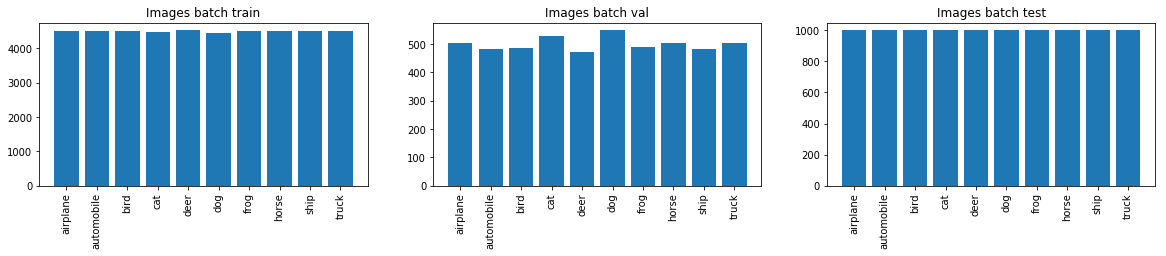

In [9]:
labels_list = [labels_train, labels_val, labels_test]
titles_list = ['Images batch '+str(i) for i in ["train", "val", 'test']]
_, axes = plt.subplots(nrows=1, ncols=len(titles_list), figsize=(20,3))
for i, (labels, title) in enumerate(zip(labels_list, titles_list)):
    unique_labels = np.unique(labels)
    axes[i].bar(unique_labels, [labels.count(x) for x in unique_labels])
    axes[i].set_xticks(unique_labels)
    axes[i].set_xticklabels(labels=label_names, rotation=90)
    axes[i].set_title(title)
plt.savefig('Figures/'+str(figure)+'_Dist_Labels.png', bbox_inches="tight"); figure+=1

Initialize the weights, bias, gammas and betas matrix (the last 2 for the *Batch Normalization*).

In [10]:
def initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True, seed=0, std=0.01): 
    k = len(hidden_dimensions)+1
    W, b, gamma, beta = [None]*k, [None]*k, [None]*(k-1), [None]*(k-1)
    n_nodes = [input_dimension]+hidden_dimensions+[output_dimension]
    
    # Define random seed and iterate layers
    np.random.seed(seed)
    for l in range(k):
        
        # Define dimensions of the layer
        inputs = n_nodes[l]
        outputs = n_nodes[l+1]
        
        # Define standard deviation for random weights and bias normal distribution
        scale = np.sqrt(2/inputs) if he else std
        
        # Initialize weights, bias, gammas and betas
        W[l] = np.random.normal(size=(outputs, inputs), loc=0, scale=scale)
        b[l] = np.zeros((outputs, 1))
        if l<(k-1):
            gamma[l] = np.ones((outputs, 1))
            beta[l] = np.zeros((outputs, 1))
        
    return W, b, gamma, beta

In [11]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50,100]
output_dimension = labels_one_hot_train.shape[0]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

The shape of the weights matrix is as many rows as output nodes and as many columns as input nodes for each layer (50 and 100 hidden nodes following the initialized example). And for the bias, gammas and betas only 1 column with as many rows as layer nodes.

In [12]:
len(W), len(b), len(gamma), len(beta)

(3, 3, 2, 2)

- Layer 1: 

In [13]:
W[0].shape, b[0].shape, gamma[0].shape, beta[0].shape

((50, 3072), (50, 1), (50, 1), (50, 1))

- Layer 2:

In [14]:
W[1].shape, b[1].shape, gamma[1].shape, beta[1].shape

((100, 50), (100, 1), (100, 1), (100, 1))

- Layer 3 (output):

In [15]:
W[2].shape, b[2].shape

((10, 100), (10, 1))

### Compute the gradients for the network parameters

Create a function to evaluate images with given parameters (forward pass).

for $l=1,...,k-1$

$$S^l = W^l \times X^{l-1} + b^l$$

$$\hat{S}^l = BatchNormalize(S^l,\mu^l,\sigma^l)$$

$$\tilde{S}^l=\gamma^l \odot \hat{S}^l + \beta^l$$

$$X^l=ReLu(\hat{S}^l) \quad where \quad ReLu(\hat{S}^l_{ij})=max(0,\hat{S}^l_{ij})$$

and then finally

$$S = W^k \times X^{k-1} + b^k$$

$$P=SoftMax(S) \quad where \quad SoftMax(S_{ji})=\frac{exp(S_{ji})}{\sum_{c=1}^C exp(S_{ci})}$$

where

$$BatchNormalize(S^l,\mu^l,\sigma^l) = diag(\sigma^l + \epsilon)^{-1}(S^l-\mu^l)$$

and $\epsilon$ is a small number, and $S^l$ and $\tilde{S}^l$, which are the un/normalized scores, have as many rows as layer nodes as well as $\mu^l$ and $\sigma^l$.

For computing the mean and standard deviation of each dimension or layer node in the batch of size $n$ we use

$$\mu^l=\frac{\sum^n_{i=1} S^l_i}{n}$$

$$\sigma^l_j=\sqrt{\frac{\sum^n_{i=1} (S^l_{ji}-\mu^l_j)^2}{n}} \quad for \quad j=1,...,\# \thinspace layer \thinspace nodes$$

but note that for validating and testing we use the means and standard deviations calculated during the training.

In [16]:
def ReLu(S):
    H = S
    H[H<0] = 0
    return H

def softmax(S):
    exponential_S = np.exp(S)
    P = exponential_S/exponential_S.sum(axis=0)
    return P

def EvaluateClassifier(X, W, b, gamma=None, beta=None, mean=None, var=None, batch_normalization=False):
    
    # Create lists for storing the parameters by layers needed in backpropagation
    k = len(W)    
    X_layers, S, S_BN = [X.copy()]+[None]*(k-1), [None]*(k-1), [None]*(k-1)
    if batch_normalization:
        if mean is None and var is None:
            return_mean_var = True
            mean, var = [None]*(k-1), [None]*(k-1)
        else:
            return_mean_var = False
    
    # Iterate the hidden layers
    for l in range(k-1):
        S[l] = W[l]@X_layers[l]+b[l]
        if batch_normalization:
            if return_mean_var:
                mean[l] = S[l].mean(axis=1).reshape(-1,1)
                var[l] = S[l].var(axis=1).reshape(-1,1)
            S_BN[l] = (S[l]-mean[l])/(np.sqrt(var[l]+1e-15))
            S_BatchNorm_Scaled = S_BN[l]*gamma[l]+beta[l]
            X_layers[l+1] = ReLu(S_BatchNorm_Scaled)
        else:
            X_layers[l+1] = ReLu(S[l])
        
    # Output layer
    P = softmax(W[k-1]@X_layers[k-1]+b[k-1])
    
    if batch_normalization:
        if return_mean_var:
            return P, S_BN, S, X_layers[1:], mean, var
        else:
            return P, S_BN, S, X_layers[1:]
    else:
        return P, X_layers[1:]

Predicting the label of the first 150 images of training, the predictions matrix shape is as many rows as possible labels and as many columns as images evaluated, and the hidden activations matrix shape is as many rows as hidden nodes (50 and 100 following the previously initialized parameters) and as many columns as images evaluated.

In [17]:
P, S_BN, S, X_layers, mean, var = EvaluateClassifier(images_train[:,0:150], W, b, gamma, beta, 
                                                     mean=None, var=None, batch_normalization=True)

In [18]:
P.shape, len(S_BN), len(S), len(X_layers), len(mean), len(var)

((10, 150), 2, 2, 2, 2, 2)

- Layer 1 shapes of: un-normalized scores, normalized scores, scaled normalized scores, mean and variance of un-normalized scores.

In [19]:
S[0].shape, S_BN[0].shape, X_layers[0].shape, mean[0].shape, var[0].shape

((50, 150), (50, 150), (50, 150), (50, 1), (50, 1))

- Layer 2 shapes of: un-normalized scores, normalized scores, scaled normalized scores, mean and variance of un-normalized scores.

In [20]:
S[1].shape, S_BN[1].shape, X_layers[1].shape, mean[1].shape, var[1].shape

((100, 150), (100, 150), (100, 150), (100, 1), (100, 1))

Define the cost function for cross entropy loss with L2 regularization term on the weights matrix.

$$J=L+\lambda \sum^k_{l=1} ||W^l||^2=\frac{1}{N}\sum_{i=1}^{N} -log\bigg(\underset{[1 \times C]}{Y_{:i}^T} \times \underset{[C \times 1]}{P_{:i}}\bigg) +\lambda \sum^k_{l=1} ||W^l||^2 $$

In [21]:
def ComputeCost(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None,var=None,batch_normalization=False):
    
    # Compute the predictions
    if batch_normalization:
        if mean is None and var is None:
            P, S_BN, S, X_layers, mean, var = \
                EvaluateClassifier(X, W, b, gamma, beta, batch_normalization=True)
        else:
            P, S_BN, S, X_layers = \
                EvaluateClassifier(X, W, b, gamma, beta, mean, var, batch_normalization=True)
    else:
        P, X_layers = EvaluateClassifier(X, W, b)
    
    # Compute the loss function term
    loss_cross = sum(-np.log((Y*P).sum(axis=0)))
    
    # Compute the regularization term
    loss_regularization = 0
    for W_l in W:
        loss_regularization += lambda_*((W_l**2).sum())
        
    # Sum the total cost
    J = loss_cross/X.shape[1]+loss_regularization
    
    return J

Define the accuracy function given somes images with the respective labels, and some parameters.

In [22]:
def ComputeAccuracy(X, y, W, b, gamma=None, beta=None, mean=None, var=None, batch_normalization=False):
    
    # Compute the predictions
    if batch_normalization:
        if mean is None and var is None:
            P, S_BN, S, X_layers, mean, var = \
                EvaluateClassifier(X, W, b, gamma, beta, batch_normalization=True)
        else:
            P, S_BN, S, X_layers = \
                EvaluateClassifier(X, W, b, gamma, beta, mean, var, batch_normalization=True)
    else:
        P, X_layers = EvaluateClassifier(X, W, b)
    
    # Compute the accuracy
    accuracy = np.mean(y==np.argmax(P, 0))
    
    return accuracy

Define the function to plot the confusion matrix given somes images with the respective labels, and some parameters.

In [23]:
def confusion_matrix(X, y, W, b, gamma=None, beta=None, mean=None, var=None, batch_normalization=False,
                     title=''):
    
    # Compute the predictions
    if batch_normalization:
        if mean is None and var is None:
            P, S_BN, S, X_layers, mean, var = \
                EvaluateClassifier(X, W, b, gamma, beta, batch_normalization=True)
        else:
            P, S_BN, S, X_layers = \
                EvaluateClassifier(X, W, b, gamma, beta, mean, var, batch_normalization=True)
    else:
        P, X_layers = EvaluateClassifier(X, W, b)
    
    # Compute the accuracy
    accuracy = ComputeAccuracy(X, y, W, b, gamma, beta, mean, var, batch_normalization)
        
    # Create the confusion matrix
    prediction = np.argmax(P, 0)
    K = len(np.unique(y))
    N = len(y)
    cross = np.zeros(shape=(K,K))
    for i in range(K):
        for j in range(K):
            cross[i,j] = np.sum([True if y[x]==i and prediction[x]==j else False for x in range(N)])
    cross = pd.DataFrame(data=cross.astype(int), columns=label_names, index=label_names)
    
    # Plot the confusion matrix
    plt.figure()
    sns.heatmap(cross, cbar=False, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Prediction")
    plt.ylabel("True label")
    plt.title("Accuracy="+str('%.2f' % (accuracy*100))+str("% ")+title)

Define the function to compute the gradients given some images and labels, the weights and the regularization parameter. Let's use the equations mentioned in the assignment intructions by data batches and then update the parameters of each layer ($W^l$, $b^l$, $\gamma^l$ and $\beta^l$) with updates equal to $-\eta_{update}$ times the respective gradients.

In [24]:
def BatchNormBackPass(G, S, mean, var):
    n = S.shape[1]
    G1 = G*(((var+1e-15)**(-0.5))@np.ones((1,n)))
    G2 = G*(((var+1e-15)**(-1.5))@np.ones((1,n)))
    D = S-mean@np.ones((1,n))
    c = (G2*D)@np.ones((n,1))
    
    return G1-(G1@np.ones((n,1)))/n-D*(c@np.ones((1,n)))/n

def ComputeGradients(X, Y, P, S_BN, S, X_layers, W, b, gamma, beta, mean,var,lambda_,batch_normalization):

    # Create lists for saving the gradients by layers
    k = len(W)
    grad_W, grad_b = [None]*k, [None]*k
    if batch_normalization:
        grad_gamma, grad_beta = [None]*(k-1), [None]*(k-1)

    # Gradient weights and bias of output layer k
    n = X.shape[1]
    X_layers = [X.copy()]+X_layers
    G = P-Y
    grad_W[k-1] = (G@X_layers[k-1].T)/n+2*lambda_*W[k-1]
    grad_b[k-1] = (G@np.ones((n,1)))/n
    
    # Propagate the gradient to layer k-1
    G = W[k-1].T@G
    G = G*(X_layers[k-1]>0)
    
    # Iterate layers k-1, ... , 1 (and in Python list indexes from k-2 to 0)
    for l in range(k-2, -1, -1):
        if batch_normalization:
            
            # Compute gradient for the scale and offset parameters
            grad_gamma[l] = ((G*S_BN[l])@np.ones((n,1)))/n
            grad_beta[l] = (G@np.ones((n,1)))/n

            # Propagate the gradients through the scale and shift
            G = G*(gamma[l]@np.ones((1,n)))

            # Propagate G through the batch normalization
            G = BatchNormBackPass(G, S[l], mean[l], var[l])
        
        # Gradient of weights and bias for layer l+1 (since for Python list indexes starts on 0)
        grad_W[l] = (G@X_layers[l].T)/n+2*lambda_*W[l]
        grad_b[l] = (G@np.ones((n,1)))/n
        
        # If layer>1 propagate G to the previous layer
        if l>0:
            G = W[l].T@G
            G = G*(X_layers[l]>0)
        
    if batch_normalization:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

#### Reformulating ComputeGradsNum.m in Python (numerically computed gradient with finite difference method)

In [25]:
def ComputeGradsNum(X, Y, lambda_, W, b, gamma, beta, mean, var, batch_normalization, h=0.000001):
    
    # Create lists for saving the gradients by layers
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if batch_normalization:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
    
    # Compute initial cost and iterate layers k
    c = ComputeCost(X, Y, lambda_, W, b, gamma, beta, mean, var, batch_normalization)
    k = len(W)
    for l in range(k):
        
        # Gradients for bias
        for i in range(b[l].shape[0]):
            b_try = [b_l.copy() for b_l in b]
            b_try[l][i,0] += h
            c2 = ComputeCost(X, Y, lambda_, W, b_try, gamma, beta, mean, var, batch_normalization)
            grad_b[l][i,0] = (c2-c)/h
        
        # Gradients for weights
        for i in range(W[l].shape[0]):
            for j in range(W[l].shape[1]):
                W_try = [W_l.copy() for W_l in W]
                W_try[l][i,j] += h
                c2 = ComputeCost(X, Y, lambda_, W_try, b, gamma, beta, mean, var, batch_normalization)
                grad_W[l][i,j] = (c2-c)/h
                
        if l<(k-1) and batch_normalization:
            
            # Gradients for gamma
            for i in range(gamma[l].shape[0]):
                gamma_try = [gamma_l.copy() for gamma_l in gamma]
                gamma_try[l][i,0] += h
                c2 = ComputeCost(X, Y, lambda_, W, b, gamma_try, beta, mean, var, batch_normalization)
                grad_gamma[l][i,0] = (c2-c)/h
            
            # Gradients for betas
            for i in range(beta[l].shape[0]):
                beta_try = [beta_l.copy() for beta_l in beta]
                beta_try[l][i,0] += h
                c2 = ComputeCost(X, Y, lambda_, W, b, gamma, beta_try, mean, var, batch_normalization)
                grad_beta[l][i,0] = (c2-c)/h
    
    if batch_normalization:
        return grad_W, grad_b, grad_gamma, grad_beta
    else:
        return grad_W, grad_b

## Exercise 1: Upgrade Assignment 2 code to train & test k-layer networks

#### Compare the numerically and analytically computed gradient (WITHOUT Batch Normalization yet)

We want to check that the gradients computed in the gradients function correspond to the correct gradients. To do this,
we compare the gradient obtained by the network with the gradient computed with the finite difference method.

*Note:* Only using the 10 first dimensions of the first 5 images of the training data and without regularization.

In [26]:
X = images_train[0:20,0:5]
Y = labels_one_hot_train[:,0:5]
lambda_ = 0

- 2-layer network (50 hiden nodes):

In [27]:
# Initialize weitghs
input_dimension = X.shape[0]
hidden_dimensions = [50]
output_dimension = Y.shape[0]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None, var=None,
                                         batch_normalization=False)

# Compute the gradients analytically
P, X_layers = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X=X, Y=Y, P=P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b, 
                                  gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                  batch_normalization=False)

print("For weights, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_W[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_W[i]-grad_W_num[i])) for i in range(len(grad_W))])

print("\nFor bias, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_b[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_b[i]-grad_b_num[i])) for i in range(len(grad_b))])

For weights, the % of absolute errors below 1e-6 by layers is:
[100.0, 99.8]
and the maxium absolute error by layers is:
[2.9144188725543918e-08, 1.0063081841149568e-06]

For bias, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0]
and the maxium absolute error by layers is:
[1.9984495735342334e-08, 8.0699704974041e-08]


- 3-layer network (50 and 50 hiden nodes):

In [28]:
# Initialize weitghs
hidden_dimensions = [50,50]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None, var=None,
                                         batch_normalization=False)

# Compute the gradients analytically
P, X_layers = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X=X, Y=Y, P=P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b,
                                  gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                  batch_normalization=False)

print("For weights, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_W[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_W[i]-grad_W_num[i])) for i in range(len(grad_W))])

print("\nFor bias, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_b[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_b[i]-grad_b_num[i])) for i in range(len(grad_b))])

For weights, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0, 100.0]
and the maxium absolute error by layers is:
[2.0314640719609756e-08, 3.6173378725745664e-07, 6.474493947083992e-07]

For bias, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0, 100.0]
and the maxium absolute error by layers is:
[1.7173585678542658e-08, 2.590849253886196e-08, 6.09979052337839e-08]


- 4-layer network (50, 50, 25 hiden nodes):

In [29]:
# Initialize weitghs
hidden_dimensions = [50,50,25]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num = ComputeGradsNum(X, Y, lambda_, W, b, gamma=None, beta=None, mean=None, var=None,
                                         batch_normalization=False)

# Compute the gradients analytically
P, X_layers = EvaluateClassifier(X, W, b)
grad_W, grad_b = ComputeGradients(X=X, Y=Y, P=P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b,
                                  gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                  batch_normalization=False)

print("For weights, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_W[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_W[i]-grad_W_num[i])) for i in range(len(grad_W))])

print("\nFor bias, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_b[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_b[i]-grad_b_num[i])) for i in range(len(grad_b))])

For weights, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0, 100.0, 100.0]
and the maxium absolute error by layers is:
[2.2375988062428576e-08, 2.4880601037780004e-07, 2.6750081116855284e-07, 1.8688928904442292e-07]

For bias, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0, 100.0, 100.0]
and the maxium absolute error by layers is:
[1.7213232311741322e-08, 1.8120693813516997e-08, 4.6682494841965294e-08, 7.998817333487729e-08]


## Exercise 2: Can I train multi-layer networks?

Define the function for the mini batch gradient descent with cyclical learning rates.

$$W^k_{t+1} = W^k_{t} - \eta_{t+1} \frac{\partial J\big(Batch^{t+1}\big)}{\partial W^k} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial W^k}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial W^k}$$

$$b^k_{t+1} = b^k_{t} - \eta_{t+1} \frac{\partial J\big(Batch^{t+1}\big)}{\partial b^k} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial b^k}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial b^k}$$

$$\gamma^k_{t+1} = \gamma^k_{t} - \eta_{t+1} \frac{\partial J\big(Batch^{t+1}\big)}{\partial \gamma^k} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial \gamma^k}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial \gamma^k}$$

$$\beta^k_{t+1} = \beta^k_{t} - \eta_{t+1} \frac{\partial J\big(Batch^{t+1}\big)}{\partial \beta^k} \quad where \quad \frac{\partial J\big(Batch^{t+1}\big)}{\partial \beta^k}= \frac{1}{N_{Batch^{t+1}}} \sum^{N_{Batch^{t+1}}}_{i=1}\frac{\partial J_i}{\partial \beta^k}$$

The tricks added in the mini batch network traning function with cyclic learning rates (Assignment 2) are:

- The option of *Batch Normalization*. Note that it is necessary to keep an exponential moving average of the batch mean and variances for the un-normalized scores of each layer, since we should use these moving averages when computing the cost and accuracy on the training and validation sets after each epoch (also for future testing). 

- It seems to be important that we randomly shuffe the order of the training data after each epoch. Since different combinations of training examples in the batches over epochs is good for regularization and estimating the mean and standard deviation averages.

In [30]:
def MiniBatchGD(X, Y, y, GDparams, lambda_, W, b, gamma=None, beta=None, X_val=None, Y_val=None,
                y_val=None, batch_normalization=False, alpha=0.9, dropout=None, jitter_noise=None):
    
    n = X.shape[1]
    eta_min = GDparams['eta_min']
    eta_max = GDparams['eta_max']
    eta_range = eta_max-eta_min
    step_size = GDparams['step_size']
    n_batch = GDparams['n_batch']
    cycles = GDparams['cycles']
    
    # Create a copy of the parameters to update
    grad_W = [W_l.copy() for W_l in W]
    grad_b = [b_l.copy() for b_l in b]
    if batch_normalization:
        grad_gamma = [gamma_l.copy() for gamma_l in gamma]
        grad_beta = [beta_l.copy() for beta_l in beta]
    
    # Create a dictionary to store the performance metrics
    metrics = {'updates':[-1],
               'loss_train':[ComputeCost(X, Y, lambda_, W, b, gamma, beta, mean=None, var=None, 
                                         batch_normalization=batch_normalization)],
               'acc_train':[ComputeAccuracy(X, y, W, b, gamma, beta, mean=None, var=None, 
                                            batch_normalization=batch_normalization)]}
    if X_val is not None:
        metrics['loss_val'] = [ComputeCost(X_val, Y_val, lambda_, W, b, gamma, beta, mean=None, var=None,
                                           batch_normalization=batch_normalization)]
        metrics['acc_val'] = [ComputeAccuracy(X_val, y_val, W, b, gamma, beta, mean=None, var=None, 
                                              batch_normalization=batch_normalization)]
    
    # Create a dictionary to save the mask of each sample by batches (if required)
    if dropout is not None:
        masks_drouput_by_batch = {}
    
    # Save original data since permutation at each epoch is required
    X_original, Y_original, y_original = X.copy(), Y.copy(), y.copy()
    
    # Define all the batches (for the first epochs since it will be shuffled each epoch)
    data_batches = {}
    max_batch_index = n//n_batch-1
    for j in range(max_batch_index+1):            
        j_start = j*n_batch
        j_end = (j+1)*n_batch
        inds = range(j_start, j_end)
        data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
        
        # Create a boolean mask (hidden activations to switch off) for each sample in the batch
        if dropout is not None:
            np.random.seed(j)
            masks_drouput_by_batch[j] = [None]*len(dropout)
            for l, dropout_l in enumerate(dropout):
                hidden_dimension = W[l].shape[0]
                masks_drouput_by_batch[j][l] = np.random.rand(hidden_dimension, n_batch) < dropout_l
    
    # Iterate cycles
    batch_index = 0
    for cycle in range(cycles):
        
        # Iterate update steps
        for t in range(2*cycle*step_size, 2*(cycle+1)*step_size):
            
            # Update the eta:
            #  - first half cycle = increasing eta
            if t>= 2*cycle*step_size and t<(2*cycle+1)*step_size:
                eta = eta_min+(t-2*cycle*step_size)/step_size*eta_range
            #  - second half cycle = decreasing eta
            elif t>=(2*cycle+1)*step_size and t<2*(cycle+1)*step_size:
                eta = eta_max-(t-(2*cycle+1)*step_size)/step_size*eta_range
            
            # Compute the forward pass
            X_batch, Y_batch, y_batch = data_batches[batch_index]
            if jitter_noise is not None:
                np.random.seed(t)
                X_batch = X_batch+np.random.normal(size=X_batch.shape, loc=0, scale=jitter_noise)
            if batch_normalization:
                P, S_BN, S, X_layers, mean, var = \
                    EvaluateClassifier(X_batch, W, b, gamma, beta, batch_normalization=True)
            else:
                P, X_layers = EvaluateClassifier(X_batch, W, b)            

            # Initialize average mean and var from the very first mini-batch update step, or update it
            if cycle==0 and t==0 and batch_normalization:
                mean_avg = mean
                var_avg = var
            elif batch_normalization:
                mean_avg = [alpha*mean_avg[l]+(1-alpha)*mean[l] for l in range(len(mean))]
                var_avg = [alpha*var_avg[l]+(1-alpha)*var[l] for l in range(len(var))]
            else:
                mean_avg = None
                var_avg = None

            # Compute gradients
            if dropout is not None:
                for l, dropout_l in enumerate(dropout):
                    S_BN[l] = S_BN[l]*masks_drouput_by_batch[batch_index][l]
            if batch_normalization:
                grad_W, grad_b, grad_gamma, grad_beta = \
                    ComputeGradients(X_batch, Y_batch, P, S_BN, S, X_layers, W, b, gamma, beta, mean, var,
                                     lambda_, batch_normalization=True)
            else:
                grad_W, grad_b = \
                    ComputeGradients(X_batch, Y_batch, P, S_BN=None, S=None, X_layers=X_layers, W=W, b=b, 
                                     gamma=None, beta=None, mean=None, var=None, lambda_=lambda_,
                                     batch_normalization=False)
            
            # Update parameters for this update/batch
            W = [W[l]-eta*grad_W[l] for l in range(len(W))]
            b = [b[l]-eta*grad_b[l] for l in range(len(b))]
            if batch_normalization:
                gamma = [gamma[l]-eta*grad_gamma[l] for l in range(len(gamma))]
                beta = [beta[l]-eta*grad_beta[l] for l in range(len(beta))]
            
            # Update the batch index for next update step
            batch_index += 1
            
            # If epoch is finished reset batch index, save metrics, and shuffle data
            if batch_index>max_batch_index:
                batch_index = 0
            
                # Save the performance metrics of the epoch (after all batches computed)
                metrics['updates'].append(t+1)
                metrics['acc_train'].append(ComputeAccuracy(X, y, W, b, gamma, beta, mean_avg, var_avg,
                                                            batch_normalization))
                metrics['loss_train'].append(ComputeCost(X, Y, lambda_, W, b, gamma, beta, mean_avg,
                                                         var_avg, batch_normalization))
                if X_val is not None:
                    metrics['acc_val'].append(ComputeAccuracy(X_val, y_val, W, b, gamma, beta, mean_avg,
                                                              var_avg, batch_normalization))
                    metrics['loss_val'].append(ComputeCost(X_val, Y_val, lambda_, W, b, gamma, beta,
                                                           mean_avg, var_avg, batch_normalization))
                
                # Show monitoring message of training
                message = "In update "+str(t+1)+'/'+str(2*cycles*step_size)+" finishes epoch "+ \
                          str(len(metrics['updates'])-1)+": loss="+str(metrics['loss_train'][-1])+ \
                          " and accuracy="+str(metrics['acc_train'][-1])+" (training set) \r"
                sys.stdout.write(message)
                
                # Suffle data and create new batches for the next epoch (after all batches computed)
                np.random.seed(t)
                permuted_indexes = np.random.permutation(n)
                X = X_original[:,permuted_indexes]
                Y = Y_original[:,permuted_indexes]
                y = [y_original[index] for index in permuted_indexes]
                
                data_batches = {}
                for j in range(max_batch_index+1):            
                    j_start = j*n_batch
                    j_end = (j+1)*n_batch
                    inds = range(j_start, j_end)
                    data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
        
    if batch_normalization:
        return W, b, gamma, beta, mean_avg, var_avg, metrics
    else:
        return W, b, metrics

#### Visualization of the learning curve

In [31]:
def plot_learning_curve(metrics, title='', step_size=None, cycles=None):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.suptitle('Learning curves '+title)
    
    # Iterate the performance metrics
    for metric, ax in zip(['loss', 'acc'], axes.flatten()):
        
        # Find the optimal metric value and the corresponding epoch for training set
        optimal_epoch_train = np.argmin(metrics[metric+'_train']) if metric=='loss' else \
                              np.argmax(metrics[metric+'_train'])
        optimal_train = np.round(metrics[metric+'_train'][optimal_epoch_train], 4)
        
        # Plot vertical red lines each step size (if required)
        if step_size is not None and cycles is not None:
            for x in np.arange(step_size, 2*step_size*cycles+1, step_size):
                label = "Step size" if x==step_size else ""
                ax.axvline(x, c="red", linestyle="--", linewidth=0.5, label=label)
        
        # Plot the learning curve of training set
        label = 'Train: '+str(optimal_train)+' at update '+str(metrics['updates'][optimal_epoch_train])+ \
                ' or epoch '+ str(optimal_epoch_train)
        ax.plot(metrics['updates'], metrics[metric+'_train'], label=label)
        
        # If validation set...
        if len(metrics)>3:
        
            # Find the optimal metric value and the corresponding epoch for training set
            optimal_epoch_val = np.argmin(metrics[metric+'_val']) if metric=='loss' else \
                                np.argmax(metrics[metric+'_val'])
            optimal_val = np.round(metrics[metric+'_val'][optimal_epoch_val], 4)
            
            # Plot the learning curve of validation set
            label = 'Validation: '+str(optimal_val)+' at update '+ \
                    str(metrics['updates'][optimal_epoch_val])+' or epoch '+str(optimal_epoch_val)
            ax.plot(metrics['updates'], metrics[metric+'_val'], label=label)
        
        # Add axis, legend and grid
        ax.set_xlabel("Update step")
        ax.set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax.legend()
        ax.grid(True)

#### 2.1: Replicate Assignment 2 results

First check, with the new version of the code, let's replicate the results achieved in Assignment 2 with a 2 layer network with 50 nodes in the hidden layer using mini-batch gradient descent with a cyclic learning rate.

In [32]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50]
output_dimension = labels_one_hot_train.shape[0]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, batch_normalization=False)

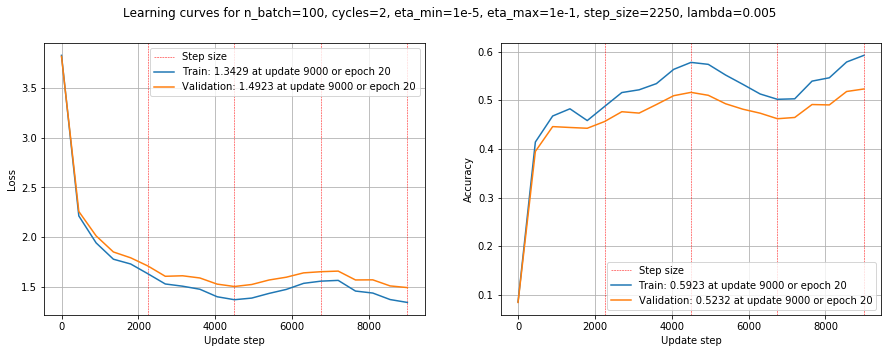

In [33]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_1_Curves.png', bbox_inches="tight"); figure+=1

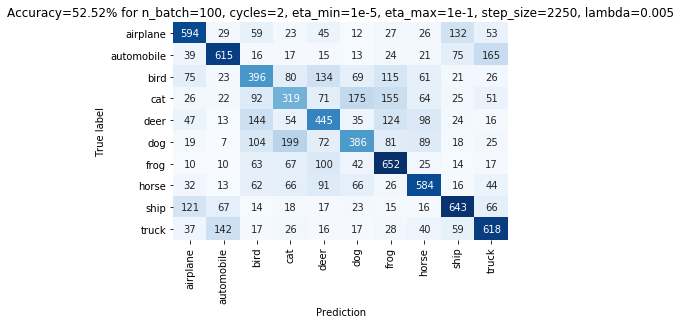

In [34]:
confusion_matrix(images_test, labels_test, W, b, batch_normalization=False, title=title)
plt.savefig('Figures/'+str(figure)+'_2_1_Confusion.png', bbox_inches="tight"); figure+=1

#### 2.2: Train a 3-layer network

Train a 3-layer network with 50 and 50 nodes in the first and second hidden layer respectively with the same learning parameters.

In [35]:
hidden_dimensions = [50,50]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, batch_normalization=False)

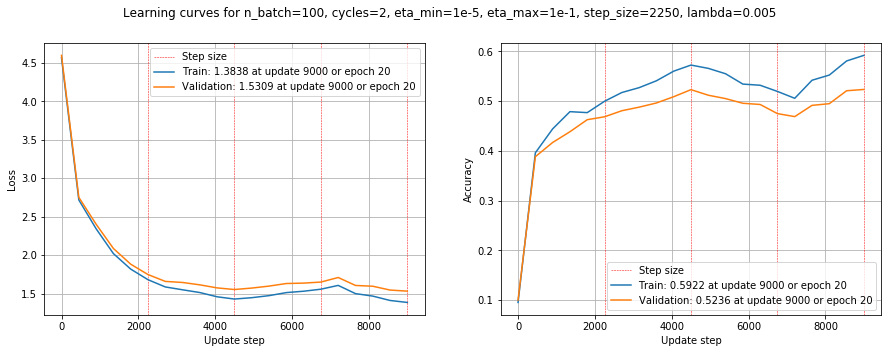

In [36]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_2_Curves.png', bbox_inches="tight"); figure+=1

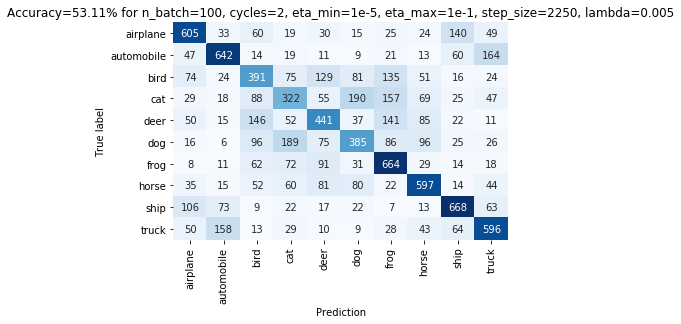

In [37]:
confusion_matrix(images_test, labels_test, W, b, batch_normalization=False, title=title)
plt.savefig('Figures/'+str(figure)+'_2_2_Confusion.png', bbox_inches="tight"); figure+=1

#### 2.3: Train a 9-layer network

Now consider a 9-layer network whose number of nodes at the hidden layers are [50, 30, 20, 20, 10, 10, 10, 10]. This network has the same number of weight parameters as the earlier network.

In [38]:
hidden_dimensions = [50,30,20,20,10,10,10,10]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val, batch_normalization=False)

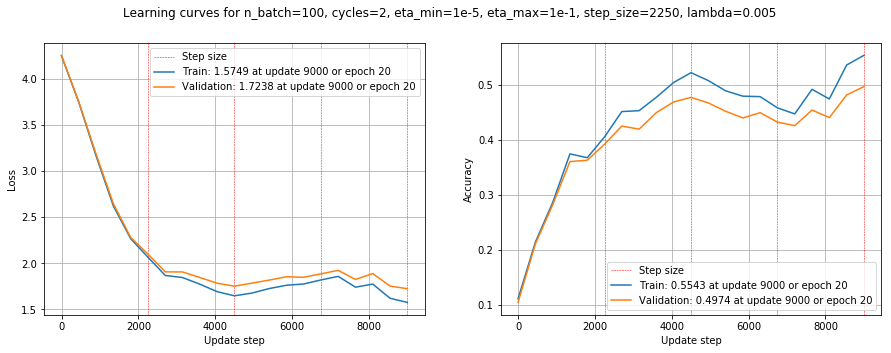

In [39]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_2_3_Curves.png', bbox_inches="tight"); figure+=1

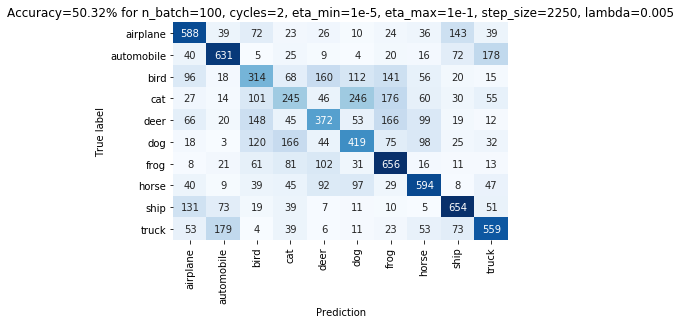

In [40]:
confusion_matrix(images_test, labels_test, W, b, batch_normalization=False, title=title)
plt.savefig('Figures/'+str(figure)+'_2_3_Confusion.png', bbox_inches="tight"); figure+=1

## Exercise 3: Implement batch normalization

#### 3.1: Compare the numerically and analytically computed gradient (WITH Batch Normalization)

We want to check that the gradients computed in the gradients function correspond to the correct gradients. To do this,
we compare the gradient obtained by the network with the gradient computed with the finite difference method.

*Note:* Only using the 10 first dimensions of the first 5 images of the training data and without regularization.

In [41]:
X = images_train[0:20,0:5]
Y = labels_one_hot_train[:,0:5]
lambda_ = 0

- 2-layer network (50 hiden nodes):

In [42]:
# Initialize weitghs
input_dimension = X.shape[0]
hidden_dimensions = [50]
output_dimension = Y.shape[0]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num = \
    ComputeGradsNum(X, Y, lambda_, W, b, gamma, beta, mean=None, var=None, batch_normalization=True)

# Compute the gradients analytically
P, S_BN, S, X_layers, mean_avg, var_avg = \
    EvaluateClassifier(X, W, b, gamma, beta, mean=None, var=None, batch_normalization=True)
grad_W, grad_b, grad_gamma, grad_beta = \
    ComputeGradients(X=X, Y=Y, P=P, S_BN=S_BN, S=S, X_layers=X_layers, W=W, b=b, gamma=gamma, beta=beta,
                     mean=mean_avg, var=var_avg, lambda_=lambda_, batch_normalization=True)

print("For weights, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_W[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_W[i]-grad_W_num[i])) for i in range(len(grad_W))])

print("\nFor bias, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_b[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_b[i]-grad_b_num[i])) for i in range(len(grad_b))])

print("\nFor gamma, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_gamma[i]-grad_gamma_num[i])<1e-6)*100 for i in range(len(grad_gamma))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_gamma[i]-grad_gamma_num[i])) for i in range(len(grad_gamma))])

print("\nFor beta, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_beta[i]-grad_beta_num[i])<1e-6)*100 for i in range(len(grad_beta))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_beta[i]-grad_beta_num[i])) for i in range(len(grad_beta))])

For weights, the % of absolute errors below 1e-6 by layers is:
[97.8, 100.0]
and the maxium absolute error by layers is:
[1.7628481202569546e-06, 6.94118412331024e-08]

For bias, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0]
and the maxium absolute error by layers is:
[1.3322676295501878e-16, 6.637334923342841e-08]

For gamma, the % of absolute errors below 1e-6 by layers is:
[100.0]
and the maxium absolute error by layers is:
[1.498743129602076e-08]

For beta, the % of absolute errors below 1e-6 by layers is:
[100.0]
and the maxium absolute error by layers is:
[2.0604879989727376e-08]


- 3-layer network (50 and 50 hiden nodes):

In [43]:
# Initialize weitghs
hidden_dimensions = [50,50]
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension)

# Compute the gradients numerically
grad_W_num, grad_b_num, grad_gamma_num, grad_beta_num = \
    ComputeGradsNum(X, Y, lambda_, W, b, gamma, beta, mean=None, var=None, batch_normalization=True)

# Compute the gradients analytically
P, S_BN, S, X_layers, mean_avg, var_avg = \
    EvaluateClassifier(X, W, b, gamma, beta, mean=None, var=None, batch_normalization=True)
grad_W, grad_b, grad_gamma, grad_beta = \
    ComputeGradients(X=X, Y=Y, P=P, S_BN=S_BN, S=S, X_layers=X_layers, W=W, b=b, gamma=gamma, beta=beta,
                     mean=mean_avg, var=var_avg, lambda_=lambda_, batch_normalization=True)

print("For weights, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_W[i]-grad_W_num[i])<1e-6)*100 for i in range(len(grad_W))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_W[i]-grad_W_num[i])) for i in range(len(grad_W))])

print("\nFor bias, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_b[i]-grad_b_num[i])<1e-6)*100 for i in range(len(grad_b))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_b[i]-grad_b_num[i])) for i in range(len(grad_b))])

print("\nFor gamma, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_gamma[i]-grad_gamma_num[i])<1e-6)*100 for i in range(len(grad_gamma))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_gamma[i]-grad_gamma_num[i])) for i in range(len(grad_gamma))])

print("\nFor beta, the % of absolute errors below 1e-6 by layers is:")
print([np.mean(np.abs(grad_beta[i]-grad_beta_num[i])<1e-6)*100 for i in range(len(grad_beta))])
print("and the maxium absolute error by layers is:")
print([np.max(np.abs(grad_beta[i]-grad_beta_num[i])) for i in range(len(grad_beta))])

For weights, the % of absolute errors below 1e-6 by layers is:
[99.6, 100.0, 100.0]
and the maxium absolute error by layers is:
[1.3681938308418573e-06, 3.949921188635408e-07, 8.375625479284388e-08]

For bias, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0, 100.0]
and the maxium absolute error by layers is:
[8.881784197001253e-17, 4.9960036108132046e-17, 6.958043688443105e-08]

For gamma, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0]
and the maxium absolute error by layers is:
[5.179347752071184e-08, 2.705595396855498e-08]

For beta, the % of absolute errors below 1e-6 by layers is:
[100.0, 100.0]
and the maxium absolute error by layers is:
[6.106766521282725e-08, 1.3721790592668981e-08]


#### 3.2: Train a 3-layer network

In [44]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50,50]
output_dimension = labels_one_hot_train.shape[0]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

# Train the network
W, b, gamma, beta, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma, beta, 
                images_val, labels_one_hot_val, labels_val, batch_normalization=True)

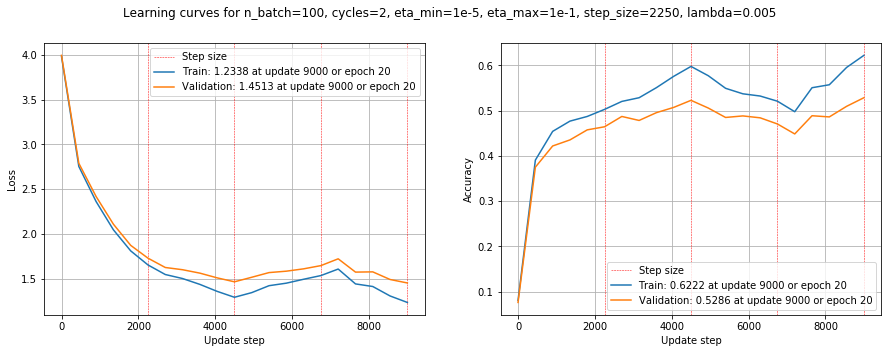

In [45]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_3_2_Curves.png', bbox_inches="tight"); figure+=1

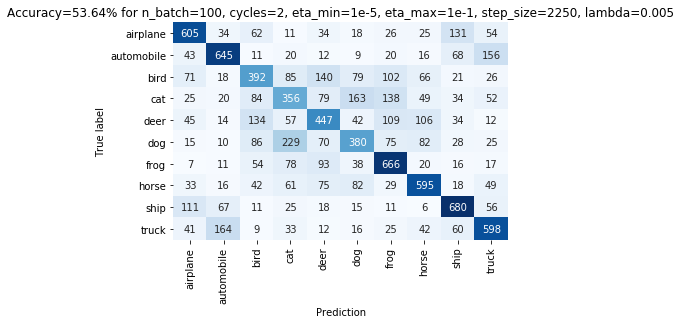

In [46]:
confusion_matrix(images_test, labels_test, W, b, gamma, beta, mean_avg, var_avg, batch_normalization=True,
                 title=title)
plt.savefig('Figures/'+str(figure)+'_3_2_Confusion.png', bbox_inches="tight"); figure+=1

#### 3.3: Coarse-to-fine search to find a good value for lambda

After you have found a good setting for lambda, you should train a network for 3 cycles and see what test accuracy this network can achieve.

First define a function for plotting the costs and accuracies for a list of $\lambda$  with a parametrization and data given.

In [47]:
def grid_search(list_lambdas, X, Y, y, GDparams, W, b, gamma, beta, batch_normalization, X_val=None, 
                Y_val=None, y_val=None, plot=True, log_scale=True):
    
    # Create a dictionary to store the performance metrics (mean/std by lambda)
    metrics_lambdas = {'lambdas':list_lambdas, 'loss_train':[], 'acc_train':[]}
    if X_val is not None:
        metrics_lambdas['loss_val'] = []
        metrics_lambdas['acc_val'] = []
        
    # Iterate the lambda values
    for lambda_ in list_lambdas:
        
        if batch_normalization:
            W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
                MiniBatchGD(X, Y, y, GDparams, lambda_, W, b, gamma, beta, X_val, Y_val, y_val, 
                            batch_normalization)
        else:
            W_, b_, metrics = \
                MiniBatchGD(X, Y, y, GDparams, lambda_, W, b, gamma, beta, X_val, Y_val, y_val, 
                            batch_normalization) 
        
        # Save the performance metrics of the lambda for this random initalization
        metrics_lambdas['loss_train'].append(metrics['loss_train'][-1])
        metrics_lambdas['acc_train'].append(metrics['acc_train'][-1])
        if X_val is not None:
            metrics_lambdas['loss_val'].append(metrics['loss_val'][-1])
            metrics_lambdas['acc_val'].append(metrics['acc_val'][-1])
                
    if plot:
        _, axes = plt.subplots(1, 2, figsize=(15,5))
        title = 'for n_batch='+str(GDparams['n_batch'])+', cycles='+str(GDparams['cycles'])+ \
                ', eta_min='+str(GDparams['eta_min'])+', eta_max='+str(GDparams['eta_max'])+ \
                ', step_size='+str(GDparams['step_size'])
        plt.suptitle('Learning curves '+title)

        # Iterate the performance metrics
        for metric, ax in zip(['loss', 'acc'], axes.flatten()):

            # Find the optimal metric value and the corresponding lambda for training set
            optimal_lambda_train = np.argmin(metrics_lambdas[metric+'_train']) if metric=='loss' \
                                   else np.argmax(metrics_lambdas[metric+'_train'])
            optimal_train = np.round(metrics_lambdas[metric+'_train'][optimal_lambda_train], 4)
            
            # Plot the learning curve of training set
            x = np.log(metrics_lambdas['lambdas']) if log_scale else metrics_lambdas['lambdas']
            y = metrics_lambdas[metric+'_train']
            label = 'Train: '+str(optimal_train)+ ' at $\lambda$ '+ \
                    str(metrics_lambdas['lambdas'][optimal_lambda_train])
            ax.plot(x, y, 'o', label=label)
            
            # If validation set...
            if len(metrics_lambdas)>3:

                # Find the optimal metric value and the corresponding lambda for training set
                optimal_lambda_val = np.argmin(metrics_lambdas[metric+'_val']) if metric=='loss' \
                                     else np.argmax(metrics_lambdas[metric+'_val'])
                optimal_val = np.round(metrics_lambdas[metric+'_val'][optimal_lambda_val], 4)
            
                # Plot the learning curve of validation set
                x = np.log(metrics_lambdas['lambdas']) if log_scale else metrics_lambdas['lambdas']
                y = metrics_lambdas[metric+'_val']
                label = 'Validation: '+str(optimal_val)+ ' at $\lambda$ '+ \
                        str(metrics_lambdas['lambdas'][optimal_lambda_val])
                ax.plot(x, y, 'o', label=label)

            # Add axis, legend and grid
            ax.set_xlabel("Log Lambdas" if log_scale else "Lambdas")
            ax.set_ylabel('Accuracy' if metric=='acc' else 'Loss')
            ax.legend()
            ax.grid(True)

    return metrics_lambdas

Define the list of lambdas to try with uniform sampling.

In [48]:
np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
list_lambdas_coarse = list(10**l)
list_lambdas_coarse.sort()
list_lambdas_coarse

[0.000341795291206101,
 0.0004950159553733192,
 0.0005627932047415164,
 0.0015119336467640998,
 0.0015676677195506057,
 0.002576638574613588,
 0.0038333321561566606,
 0.007257005721594274,
 0.03690557729213758,
 0.07155682161754859]

Let's do the coarse search with the same hyperparametrization than before.

- 45.000 images for train and 5.000 for validation
- eta_min=1e-5 and eta_max=1e-1
- cycles = 2
- n_batch = 100
- step_size = 5 · epochs = 5 · # images / n_batch = 2 · 45.000 / 100 = 2250

*Note*: If step_size = 5 · epochs, then 2 cycles is equivalent to 20 epoch = 2 cycles · 5 · 2 epochs

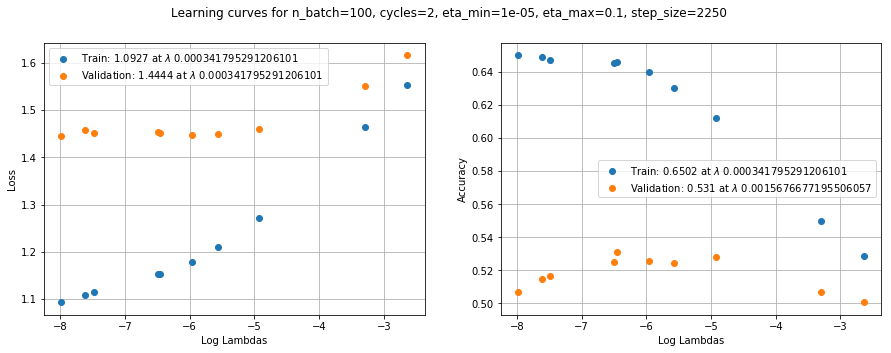

In [49]:
# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Run the search for lambda
metrics_by_lambdas_coarse = \
    grid_search(list_lambdas_coarse, images_train, labels_one_hot_train, labels_train, GDparams, W, b, 
                gamma, beta, batch_normalization=True, X_val=images_val, Y_val=labels_one_hot_val, 
                y_val=labels_val, plot=True, log_scale=True)

plt.savefig('Figures/'+str(figure)+'_3_3_Coarse.png', bbox_inches="tight"); figure+=1

#### 3.4: Train a 3-layer network with optimal $\lambda$ (3 cycles)

In [50]:
# Define the network parameters
lambda_optimal = 0.0015
GDparams['cycles'] = 3

# Train the network
W, b, gamma, beta, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_optimal, W, b, gamma,
                beta, images_val, labels_one_hot_val, labels_val, batch_normalization=True)

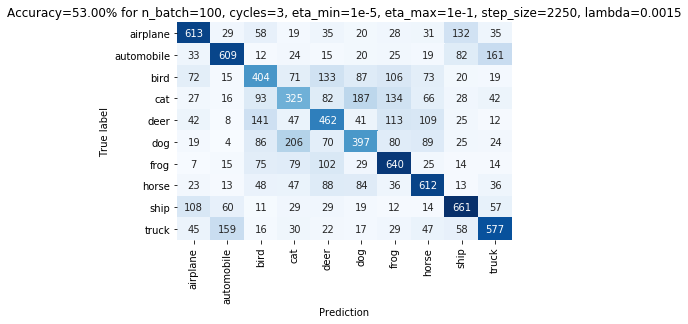

In [51]:
title = 'for n_batch=100, cycles=3, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.0015'
confusion_matrix(images_test, labels_test, W, b, gamma, beta, mean_avg, var_avg, batch_normalization=True,
                 title=title)
plt.savefig('Figures/'+str(figure)+'_Confusion_3_4_Confusion.png', bbox_inches="tight"); figure+=1

#### 3.5: Train a 9-layer network

In [52]:
hidden_dimensions = [50,30,20,20,10,10,10,10]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Train the network
W, b, gamma, beta, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma, beta,
                images_val, labels_one_hot_val, labels_val, batch_normalization=True)

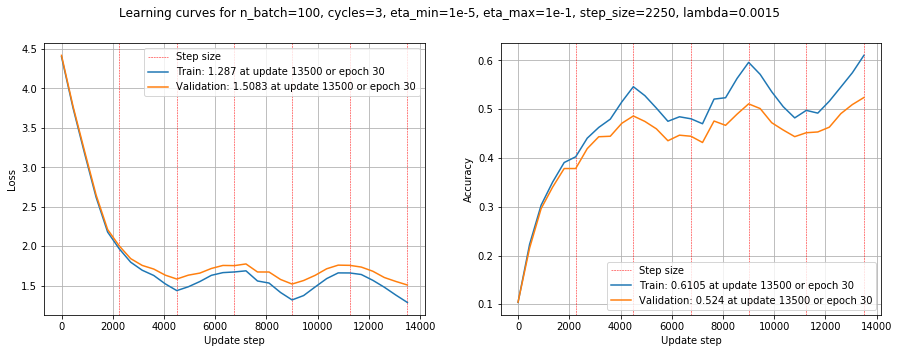

In [53]:
# Plot the learning curve
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_3_5_Curves.png', bbox_inches="tight"); figure+=1

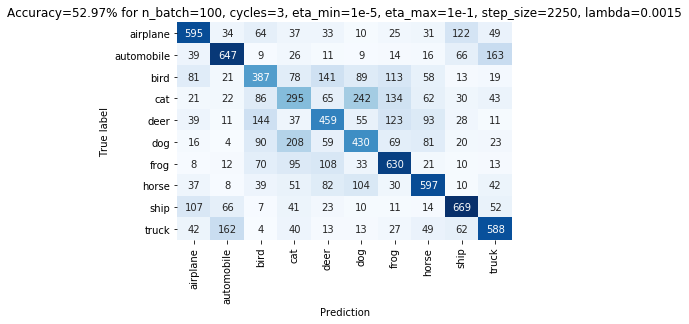

In [54]:
confusion_matrix(images_test, labels_test, W, b, gamma, beta, mean_avg, var_avg, batch_normalization=True,
                 title=title)
plt.savefig('Figures/'+str(figure)+'_3_5_Confusion.png', bbox_inches="tight"); figure+=1

#### 3.6: Pros of Batch Normalization and sensitivity to initialization

In [55]:
hidden_dimensions = [50,50]

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

results = np.array(["Sigma","Batch Normalization","Test Accuracy"])

for sigma in [1e-1,1e-3,1e-4]:
    
    # Initialize weitghs
    W, b, gamma, beta = \
        initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=False, std=sigma)

    for batch_normalization in [False,True]:
        
        # Train the network
        if batch_normalization:
            W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
                MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                            gamma, beta, images_val, labels_one_hot_val, labels_val, 
                            batch_normalization=True)
        else:
            W_, b_, metrics = \
                MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, 
                            X_val=images_val, Y_val=labels_one_hot_val, y_val=labels_val,
                            batch_normalization=False)
            gamma_, beta_, mean_avg, var_avg = None, None, None, None
            
        # Save test accuracy
        accuracy_test = ComputeAccuracy(images_test, labels_test, W_, b_, gamma_, beta_, mean_avg, 
                                        var_avg, batch_normalization)
        results = np.vstack((results,[sigma,batch_normalization,accuracy_test]))

results

array([['Sigma', 'Batch Normalization', 'Test Accuracy'],
       ['0.1', '0.0', '0.5296'],
       ['0.1', '1.0', '0.5378'],
       ['0.001', '0.0', '0.1'],
       ['0.001', '1.0', '0.536'],
       ['0.0001', '0.0', '0.1'],
       ['0.0001', '1.0', '0.536']], dtype='<U32')

## Exercise 4: Optional for bonus points

### 4.1. Optimize the performance of the network

We will compare the results of next tricks or modifications with the default parametrization of the assignment: test acuracy 53.64% and in validation 52.86%.

- 45.000 images for train and 5.000 for validation
- eta_min=1e-5 and eta_max=1e-1
- cycles = 2
- n_batch = 100
- step_size = 5 · epochs = 5 · # images / n_batch = 2 · 45.000 / 100 = 2250

*Note*: If step_size = 5 · epochs, then 2 cycles is equivalent to 20 epoch = 2 cycles · 5 · 2 epochs

In [56]:
input_dimension = images_train.shape[0]
hidden_dimensions = [50,50]
output_dimension = labels_one_hot_train.shape[0]

# Initialize weitghs
W, b, gamma, beta = initialize_weights(input_dimension, hidden_dimensions, output_dimension, he=True)

# Define the network parameters
lambda_ = 0.005
GDparams = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':int(5*45000/100), 'cycles':2}

#### 4.1.a

Do a more exhaustive random search to find good values for the amount of regularization. Firstly, define the list of lambdas looking for the optimal range in the coarse search previously done.

In [57]:
list_lambdas_fine = np.arange(0.001, 0.015, 0.0025)
list_lambdas_fine

array([0.001 , 0.0035, 0.006 , 0.0085, 0.011 , 0.0135])

Let's do the fine search with the same referecence hyperparametrization.

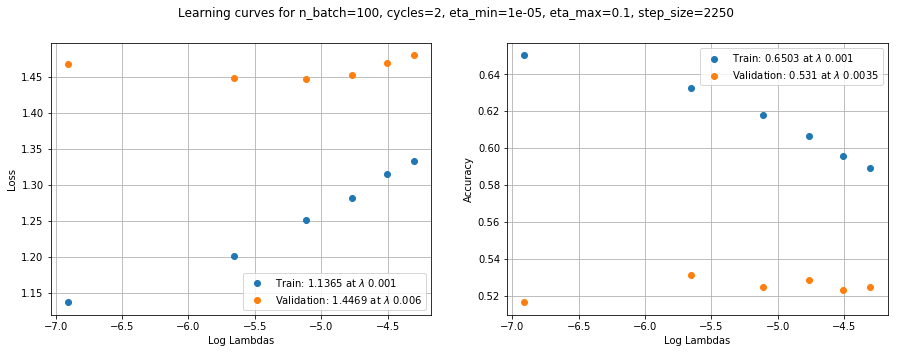

In [58]:
# Run the search for lambda
metrics_by_lambdas_fine = \
    grid_search(list_lambdas_fine, images_train, labels_one_hot_train, labels_train, GDparams, W, b, 
                gamma, beta, batch_normalization=True, X_val=images_val, Y_val=labels_one_hot_val, 
                y_val=labels_val, plot=True, log_scale=True)

plt.savefig('Figures/'+str(figure)+'_4_a_Fine_Search.png', bbox_inches="tight"); figure+=1

The test accuracy of the best lambda is:

In [59]:
lambda_optimal = 0.0085

W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_optimal, W, b, gamma, 
                beta, images_val, labels_one_hot_val, labels_val, batch_normalization=True)

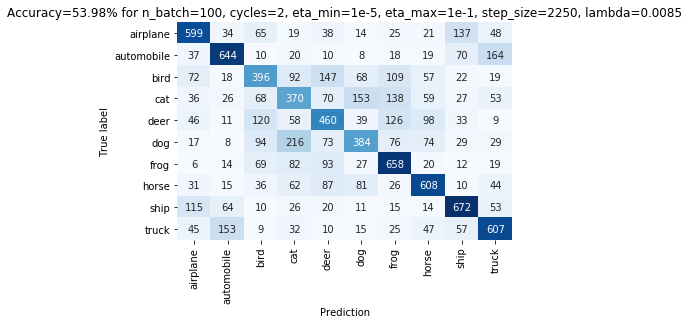

In [60]:
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.0085'
confusion_matrix(images_test, labels_test, W_, b_, gamma_, beta_, mean_avg, var_avg, 
                 batch_normalization=True, title=title)
plt.savefig('Figures/'+str(figure)+'_4_1_Confusion.png', bbox_inches="tight"); figure+=1

#### 4.1.b

Do a more thorough search to find a good network architecture. Does making the network deeper improve performance?

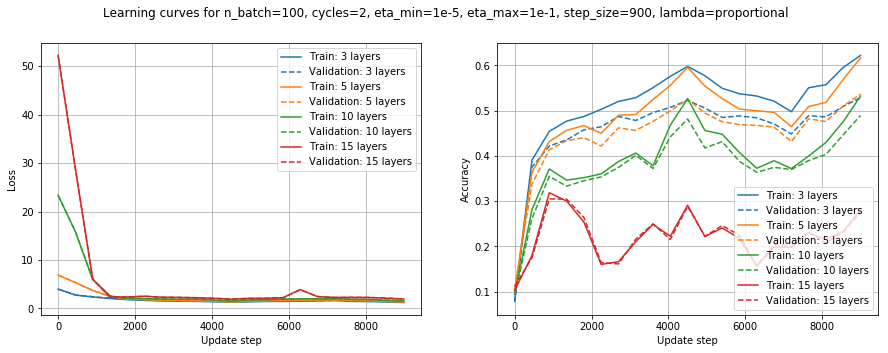

In [61]:
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=900, lambda=proportional'
_, axes = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Learning curves '+title)

# Iterate the hidden nodes to try
cmap = plt.get_cmap('tab10')
list_hidden_dimensions = [[50]*2,[50]*4,[50]*9,[50]*14]
for i, hidden_dimensions in enumerate(list_hidden_dimensions):
    
    # Initialize weitghs
    W_, b_, gamma_, beta_ = initialize_weights(input_dimension, hidden_dimensions, output_dimension)
    
    # Set a proportional lambda to the initial 50 hidden nodes
    lambda_prop = lambda_*len(hidden_dimensions)/2
    
    # Train the network
    W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
        MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_prop, W_, b_,
                    gamma_, beta_, images_val, labels_one_hot_val, labels_val, batch_normalization=True)
    
    # Plot the loss learning curve of training and validation set
    label_0 = "Train: "+str(len(hidden_dimensions)+1)+" layers"
    label_1 = "Validation: "+str(len(hidden_dimensions)+1)+" layers"
    axes[0].plot(metrics['updates'], metrics['loss_train'], label=label_0, c=cmap(i))
    axes[0].plot(metrics['updates'], metrics['loss_val'], label=label_1, linestyle="--", c=cmap(i))
        
    # Plot the accuracy learning curve of training and validation set
    axes[1].plot(metrics['updates'], metrics['acc_train'], label=label_0, c=cmap(i))
    axes[1].plot(metrics['updates'], metrics['acc_val'], label=label_1, linestyle="--",  c=cmap(i))

# Add axis, legend and grid
axes[0].set_xlabel("Update step")
axes[1].set_xlabel("Update step")
axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Accuracy')
axes[0].legend()
axes[1].legend()
axes[0].grid(True)
axes[1].grid(True)

plt.savefig('Figures/'+str(figure)+'_4_b.png', bbox_inches="tight"); figure+=1

#### 4.1.d

Apply dropout to your training if you have a high number of hidden nodes and you feel you need more regularization.

In [62]:
# Train the network
W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma, beta,
                images_val, labels_one_hot_val, labels_val, batch_normalization=True, dropout=[0.75,0.75])

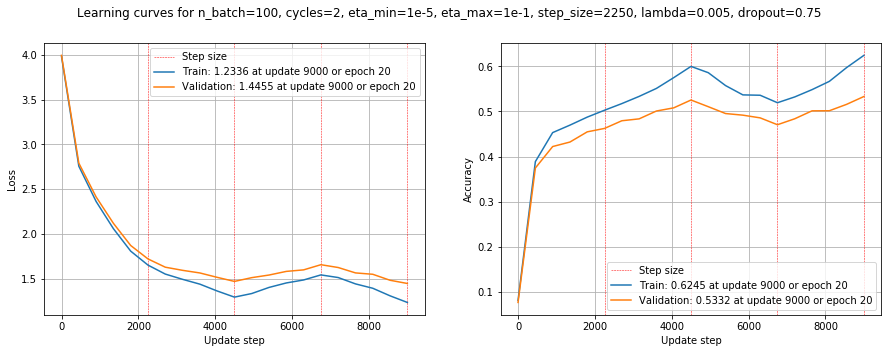

In [63]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250,lambda=0.005,dropout=0.75'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_4_d_Curves.png', bbox_inches="tight"); figure+=1

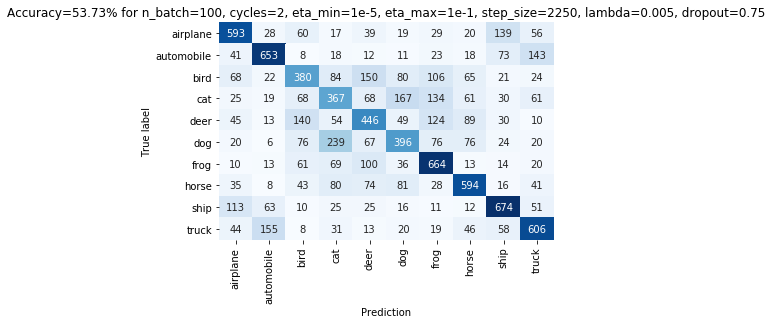

In [64]:
confusion_matrix(images_test, labels_test, W_, b_, gamma_, beta_, mean_avg, var_avg,
                 batch_normalization=True, title=title)
plt.savefig('Figures/'+str(figure)+'_4_d_Confusion.png', bbox_inches="tight"); figure+=1

#### 4.1.e

Augment your training data by applying small random geometric and photometric jitter to the original training data. You can do this on the fly by applying a random jitter to each image in the mini-batch before doing the forward and backward pass.

In [65]:
# Train the network
W_, b_, gamma_, beta_, mean_avg, var_avg, metrics = \
    MiniBatchGD(images_train, labels_one_hot_train, labels_train, GDparams, lambda_, W, b, gamma, beta,
                images_val, labels_one_hot_val, labels_val, batch_normalization=True, jitter_noise=0.1)

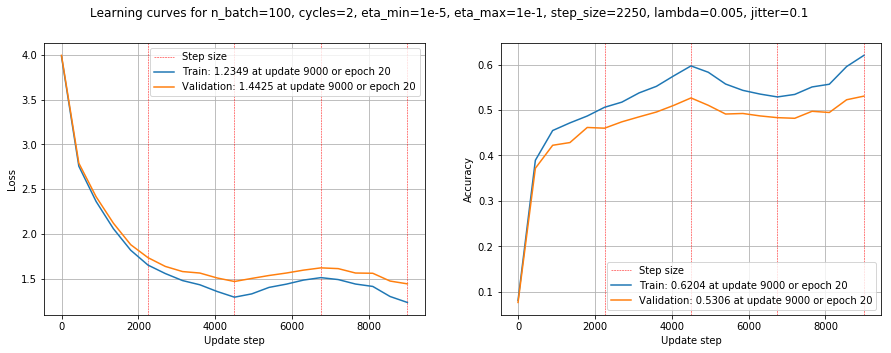

In [66]:
# Plot the learning curve
title = 'for n_batch=100, cycles=2, eta_min=1e-5, eta_max=1e-1, step_size=2250, lambda=0.005, jitter=0.1'
plot_learning_curve(metrics, title=title, step_size=GDparams['step_size'], cycles=GDparams['cycles'])
plt.savefig('Figures/'+str(figure)+'_4_e_Curves.png', bbox_inches="tight"); figure+=1

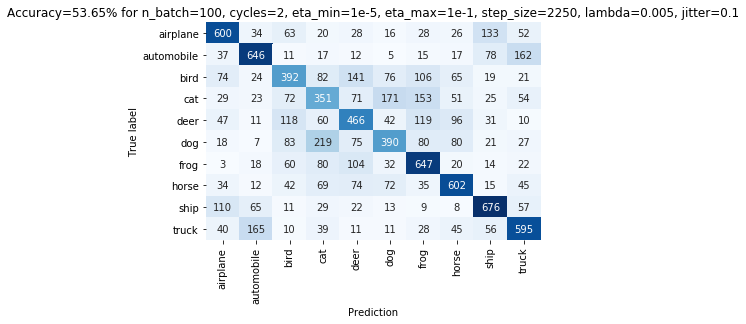

In [67]:
confusion_matrix(images_test, labels_test, W_, b_, gamma_, beta_, mean_avg, var_avg,
                 batch_normalization=True, title=title)
plt.savefig('Figures/'+str(figure)+'_4_e_Confusion.png', bbox_inches="tight"); figure+=1